In [129]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
import warnings
warnings.filterwarnings("ignore")


In [167]:
#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer



In [130]:
print(os.getcwd())

c:\Users\User Laptop\Desktop\Projekt_\projekt_dental\notebooks


In [131]:
df = pd.read_excel("../data/processed_data/merged_df_25.08last.xlsx")

In [132]:
df.head(5)

,Location,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer
0,Angola,2019,70.2,2.3,4.0,23.9,27.2,37.8,195.8,482,166,316
1,Burundi,2019,1.3,0.1,2.0,19.2,31.7,41.6,5.3,92,30,62
2,Benin,2019,3.3,0.3,2.9,27.1,29.5,39.6,30.0,74,42,32
3,Burkina Faso,2019,4.6,0.2,1.9,27.4,27.5,40.3,30.8,179,55,124
4,Botswana,2019,57.4,24.1,7.5,26.3,32.7,37.6,59.2,60,8,52


| Sütun Adı                      | Açıklama                                                                   |
|--------------------------------|----------------------------------------------------------------------------|
| Location                       | Ülke adı (örneğin: Angola)                                                 | | Period                         | Veri yılı (örneğin: 2019)                                                  |
| TotalExpenditure               | Diş Sağlığı Hizmetleri – Toplam Harcama (US$)                              |
| PerCapitaExpenditure           | Kişi Başına Diş Sağlığı Harcaması (US$)                                    |
| EdentulismRate                 | 20 Yaş Üstü Bireylerde Dişsizlik Yaygınlığı (%)                            |
| PeriodontalRate                | 15 Yaş Üstü Bireylerde Şiddetli Periodontal Hastalık Yaygınlığı (%)        |
| UntreatedCariesRate            | 5 Yaş Üstü Bireylerde Kalıcı Dişlerde Tedavi Edilmemiş Çürük Yaygınlığı (%)|
| UntreatedDeciduousCaries1_9Rate| 1–9 Yaş Arası Çocuklarda Süt Dişi Çürüğü (Tedavi Edilmemiş) Yaygınlığı     |
| ProductivityLossRate           | 5 Ağız Hastalığı Nedeniyle Toplam Üretkenlik Kaybı (US$)                   |
| both_cancer                    | Dudak ve Ağız Boşluğu Kanseri: Toplam nüfus icin yeni vaka sayisi          |
| female_cancer                  | Dudak ve Ağız Boşluğu Kanseri: Kadinlar icin yeni vaka sayisi              |
| male_cancer                    | Dudak ve Ağız Boşluğu Kanseri: Erkekler icin yeni vaka sayisi              |


In [133]:
# Tüm string sütunlarda boşlukları kaldır
df = df.apply(lambda col: col.str.replace(" ", "", regex=False) if col.dtype == "object" else col)

In [134]:
#Tekrarlayan satirimiz var mi
df.duplicated().any()


False

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Location                          192 non-null    object 
 1   Period                            192 non-null    int64  
 2   TotalExpenditure                  192 non-null    object 
 3   PerCapitaExpenditure              192 non-null    float64
 4   EdentulismRate                    192 non-null    float64
 5   PeriodontalRate                   192 non-null    float64
 6   UntreatedCariesRate               192 non-null    float64
 7   UntreatedDeciduousCaries11_9Rate  192 non-null    float64
 8   ProductivityLossRate              192 non-null    object 
 9   both_cancer                       174 non-null    object 
 10  female_cancer                     171 non-null    object 
 11  male_cancer                       174 non-null    object 
dtypes: float

##### Sadece sayisal olmasi gereken sütunlari sayisal ver tipine gönüstürme

In [136]:
# 'period' ve 'location' dışındaki sütunları seç
cols_to_convert = [col for col in df.columns if col not in ['Period', 'Location']]

# Sadece bu sütunları numeric'e çevir
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')


In [137]:
df.dtypes

Location                             object
Period                                int64
TotalExpenditure                    float64
PerCapitaExpenditure                float64
EdentulismRate                      float64
PeriodontalRate                     float64
UntreatedCariesRate                 float64
UntreatedDeciduousCaries11_9Rate    float64
ProductivityLossRate                float64
both_cancer                         float64
female_cancer                       float64
male_cancer                         float64
dtype: object

In [138]:
df[df["female_cancer"].isna() & df["both_cancer"].notna()]


,Location,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer
10,Comoros,2019,0.3,0.3,2.9,22.8,32.3,40.3,2.7,5.0,NaN,5.0
49,Bahamas,2019,32.9,514.9,6.4,25.9,28.7,43.9,47.8,5.0,NaN,5.0
161,Maldives,2019,0.6,1.7,3.2,8.1,28.0,44.0,15.5,5.0,NaN,5.0


In [139]:
# Koşullu olarak NaN → 0
df.loc[df["female_cancer"].isna() & df["both_cancer"].notna(), "female_cancer"] = 0


In [140]:
df[df["female_cancer"].isna() & df["both_cancer"].notna()]


,Location,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer


In [141]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Period,192.0,2019.000000,0.000000,2019.0,2019.000,2019.00,2019.000,2019.0
TotalExpenditure,192.0,2016.106771,11135.195720,0.0,3.500,45.60,227.275,133505.8
PerCapitaExpenditure,192.0,54.919271,115.728152,0.0,0.675,9.20,39.525,867.2
EdentulismRate,192.0,7.644792,3.965027,1.2,4.300,7.50,10.625,16.8
PeriodontalRate,192.0,18.439583,6.910702,2.3,15.175,19.20,23.725,33.5
UntreatedCariesRate,192.0,32.256250,4.520687,21.9,29.200,31.85,35.500,49.5
UntreatedDeciduousCaries11_9Rate,192.0,41.733854,6.347399,18.7,39.075,43.60,46.500,53.2
ProductivityLossRate,192.0,1680.660417,7038.217347,0.1,21.950,103.65,744.250,78468.5
both_cancer,174.0,2124.356322,10860.615852,2.0,60.250,203.00,858.250,135929.0
female_cancer,174.0,646.954023,2673.235330,0.0,23.250,89.50,302.000,31268.0


In [142]:
# Eksik değerleri kontrol et
print(df.isna().sum())

Location                             0
Period                               0
TotalExpenditure                     0
PerCapitaExpenditure                 0
EdentulismRate                       0
PeriodontalRate                      0
UntreatedCariesRate                  0
UntreatedDeciduousCaries11_9Rate     0
ProductivityLossRate                 0
both_cancer                         18
female_cancer                       18
male_cancer                         18
dtype: int64


In [143]:
# 
# Kanser sütunları (both/female/male) -> NaN bırak
# Eksik değerleri 0 ile doldurmuyoruz, böylece analizde hatalı yorum olmaz


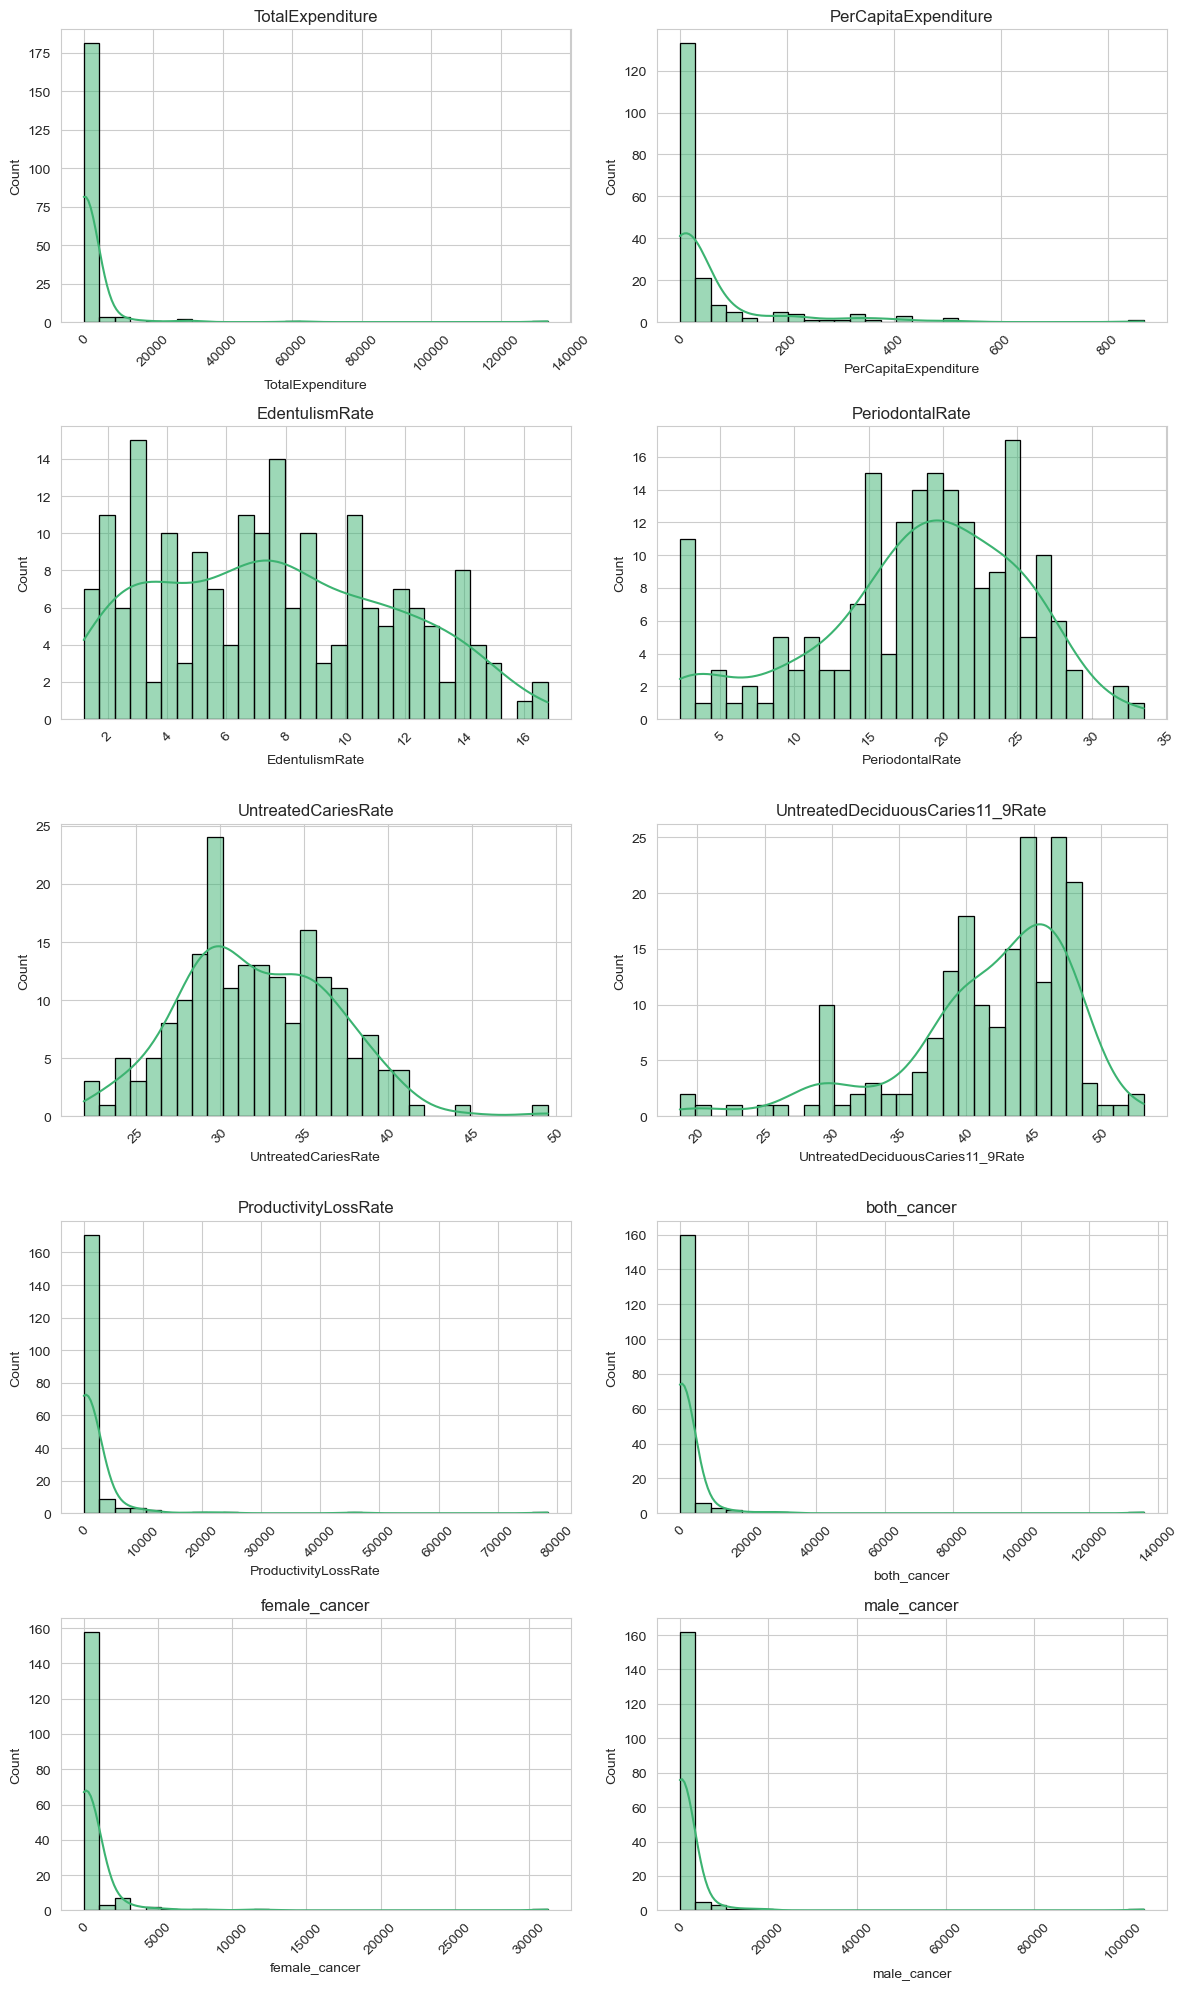

In [144]:
numeric_cols = [col for col in df.columns if col not in ['Period', 'Location']]
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))

for i, col in enumerate(numeric_cols):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    
    # Histogram + KDE (trendline)
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color='mediumseagreen', edgecolor='black')
    
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

# Fazla boş subplotları kaldır
if len(numeric_cols) % n_cols != 0:
    for j in range(len(numeric_cols), n_rows*n_cols):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


In [145]:
#En çok harcama yapan 10 ülke
top_total_expenditure = df.sort_values("TotalExpenditure", ascending=False).head(10)

print("En çok harcama yapan 10 ülke:")
print(top_total_expenditure[["Location", "TotalExpenditure", "PerCapitaExpenditure"]].to_string(index=False))


En çok harcama yapan 10 ülke:
                                     Location  TotalExpenditure  PerCapitaExpenditure
                        UnitedStatesofAmerica          133505.8                 405.5
                                        China           61548.6                  44.0
                                      Germany           30877.3                 372.2
                                        Japan           28733.6                 227.7
                                        Italy           19123.0                 316.8
                                       Canada           12829.1                 342.5
                                       France           12666.0                 195.4
UnitedKingdomofGreatBritainandNorthernIreland            9576.9                 143.2
                                        Spain            8306.3                 178.0
                                    Australia            7370.3                 288.3


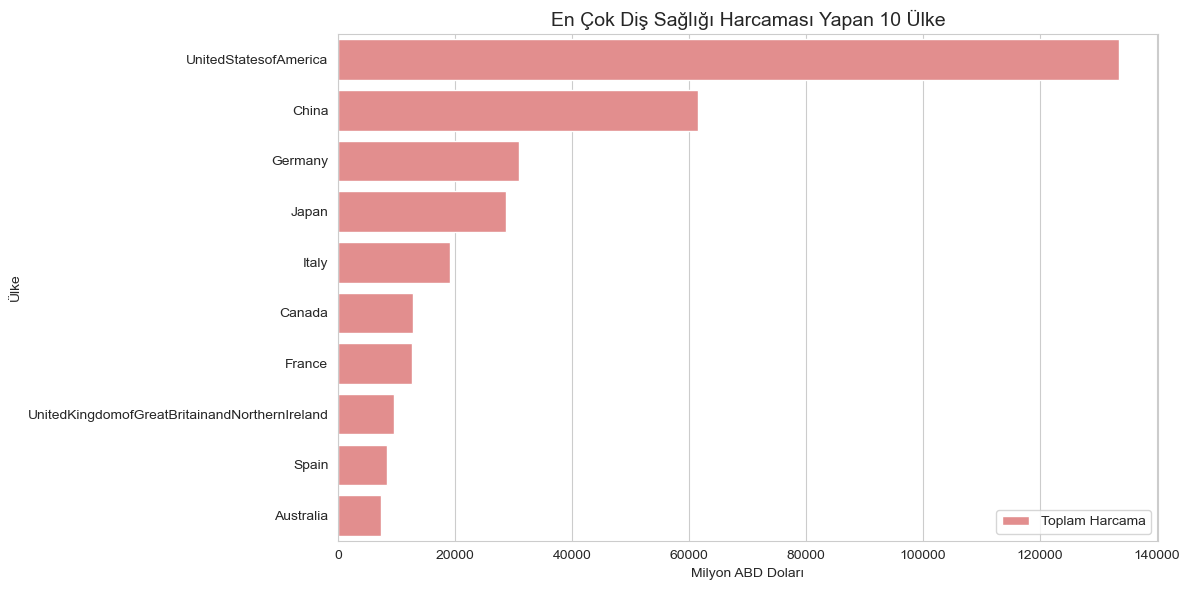

In [146]:
# En çok harcama yapan 10 ülkeyi seç
top_total_expenditure = df.sort_values("TotalExpenditure", ascending=False).head(10)

# Grafik boyutu ve stil
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Toplam harcama çubuğu
sns.barplot(
    x="TotalExpenditure",
    y="Location",
    data=top_total_expenditure,
    color="lightcoral",
    label="Toplam Harcama"
)


# Başlık ve açıklamalar
plt.title("En Çok Diş Sağlığı Harcaması Yapan 10 Ülke", fontsize=14)
plt.xlabel("Milyon ABD Doları")
plt.ylabel("Ülke")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [147]:
# En düşük harcama yapan 10 ülke
low_total_expenditure = df.sort_values("TotalExpenditure", ascending=True).head(10)
print("\nEn düşük harcama yapan 10 ülke:")
print(low_total_expenditure[["Location", "TotalExpenditure", "PerCapitaExpenditure"]])


En düşük harcama yapan 10 ülke:
                     Location  TotalExpenditure  PerCapitaExpenditure
21                      Kenya               0.0                   0.0
173                  Cambodia               0.0                   0.0
18                     Gambia               0.0                   0.0
88                       Iraq               0.0                   0.0
31                      Niger               0.0                   0.0
157                    Bhutan               0.0                   0.1
42   UnitedRepublicofTanzania               0.1                   0.0
188                    Tuvalu               0.1                   6.8
190                   Vanuatu               0.1                   0.5
14                   Ethiopia               0.1                   0.0


In [148]:
health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate","ProductivityLossRate"]

# Ülkeleri toplam harcama sırasına göre göster
df_top_spenders_health = top_total_expenditure[["Location"] + health_cols]
print("\nEn çok harcama yapan 10 ülkenin sağlık göstergeleri:")

# Tek satırda göstermek için
print(df_top_spenders_health.to_string(index=False))



En çok harcama yapan 10 ülkenin sağlık göstergeleri:
                                     Location  EdentulismRate  PeriodontalRate  UntreatedCariesRate  UntreatedDeciduousCaries11_9Rate  ProductivityLossRate
                        UnitedStatesofAmerica            10.2             15.7                 24.3                              42.6               78468.5
                                        China             5.7             17.5                 24.6                              47.2               45713.1
                                      Germany            11.7             27.4                 31.7                              29.1               19395.9
                                        Japan            11.7             20.6                 25.8                              39.5               23663.0
                                        Italy            12.9             18.2                 29.6                              36.1                9541.6
          

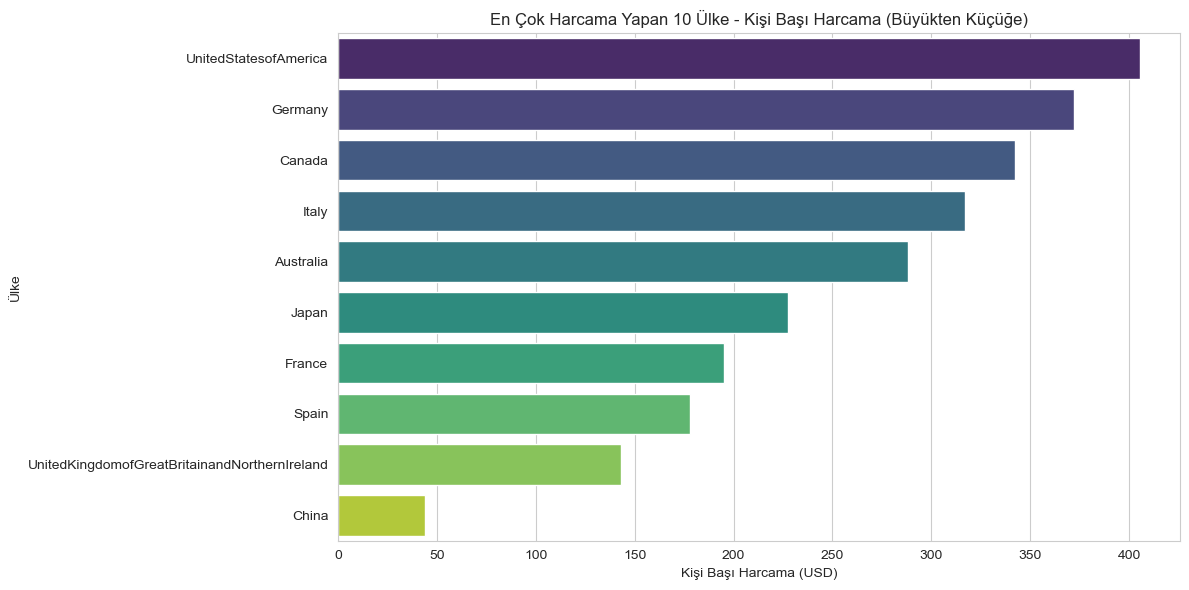

In [149]:
# Kişi başı harcamaya göre büyükten küçüğe sıralama
sorted_df = top_total_expenditure.sort_values("PerCapitaExpenditure", ascending=False)

# Grafik
plt.figure(figsize=(12, 6))
sns.barplot(
    x="PerCapitaExpenditure",
    y="Location",
    data=sorted_df,
    palette="viridis"
)

plt.title("En Çok Harcama Yapan 10 Ülke - Kişi Başı Harcama (Büyükten Küçüğe)")
plt.xlabel("Kişi Başı Harcama (USD)")
plt.ylabel("Ülke")
plt.tight_layout()
plt.show()


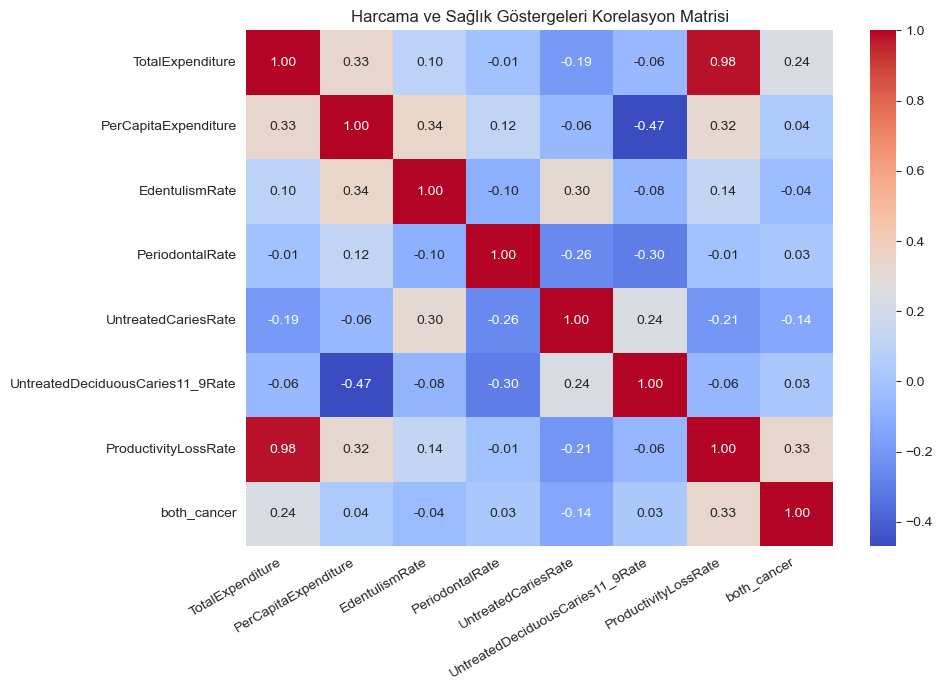

In [150]:
# Sayısal sütunları seç
numeric_for_corr = [col for col in df.columns if col not in ['Period', 'Location','female_cancer', 'male_cancer']]

# Korelasyon matrisi
corr = df[numeric_for_corr].corr()

# Görselleştirme
plt.figure(figsize=(10, 7))
ax = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

# X ekseni etiketlerini 45 derece döndür
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.title("Harcama ve Sağlık Göstergeleri Korelasyon Matrisi")
plt.tight_layout()
plt.show()


In [152]:
# TotalExpenditure'e göre 3 gruba ayır (Low, Medium, High)
df["ExpenditureGroup"] = pd.qcut(df["TotalExpenditure"], 3, labels=["Low", "Medium", "High"])

# Gruplara göre sağlık göstergelerinin ortalaması
health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate", "ProductivityLossRate"]

grouped_health = df.groupby("ExpenditureGroup")[health_cols].mean()
print("Harcama gruplarına göre sağlık göstergelerinin ortalaması:")
print(grouped_health)

Harcama gruplarına göre sağlık göstergelerinin ortalaması:
                  EdentulismRate  PeriodontalRate  UntreatedCariesRate  \
ExpenditureGroup                                                         
Low                     4.493750        18.701563            31.628125   
Medium                  8.445312        17.728125            32.607813   
High                    9.995313        18.889063            32.532812   

                  UntreatedDeciduousCaries11_9Rate  ProductivityLossRate  
ExpenditureGroup                                                          
Low                                      42.221875             37.326563  
Medium                                   43.009375            273.854688  
High                                     39.970312           4730.800000  


In [153]:
# Harcama gruplarına göre sağlık göstergelerinin ortalaması
grouped_health = df.groupby("ExpenditureGroup")[health_cols].mean()

# Daha okunaklı ve görsel olarak zengin tablo
styled_table = grouped_health.style\
    .format("{:.4f}")\
    .background_gradient(cmap="YlGnBu")\
    .set_caption("Harcama Gruplarına Göre Sağlık Göstergeleri Ortalamaları")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'black'), ('font-size', '14px'), ('font-weight', 'bold')]
    }])

styled_table

,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate
ExpenditureGroup,,,,,
Low,4.4938,18.7016,31.6281,42.2219,37.3266
Medium,8.4453,17.7281,32.6078,43.0094,273.8547
High,9.9953,18.8891,32.5328,39.9703,4730.8000


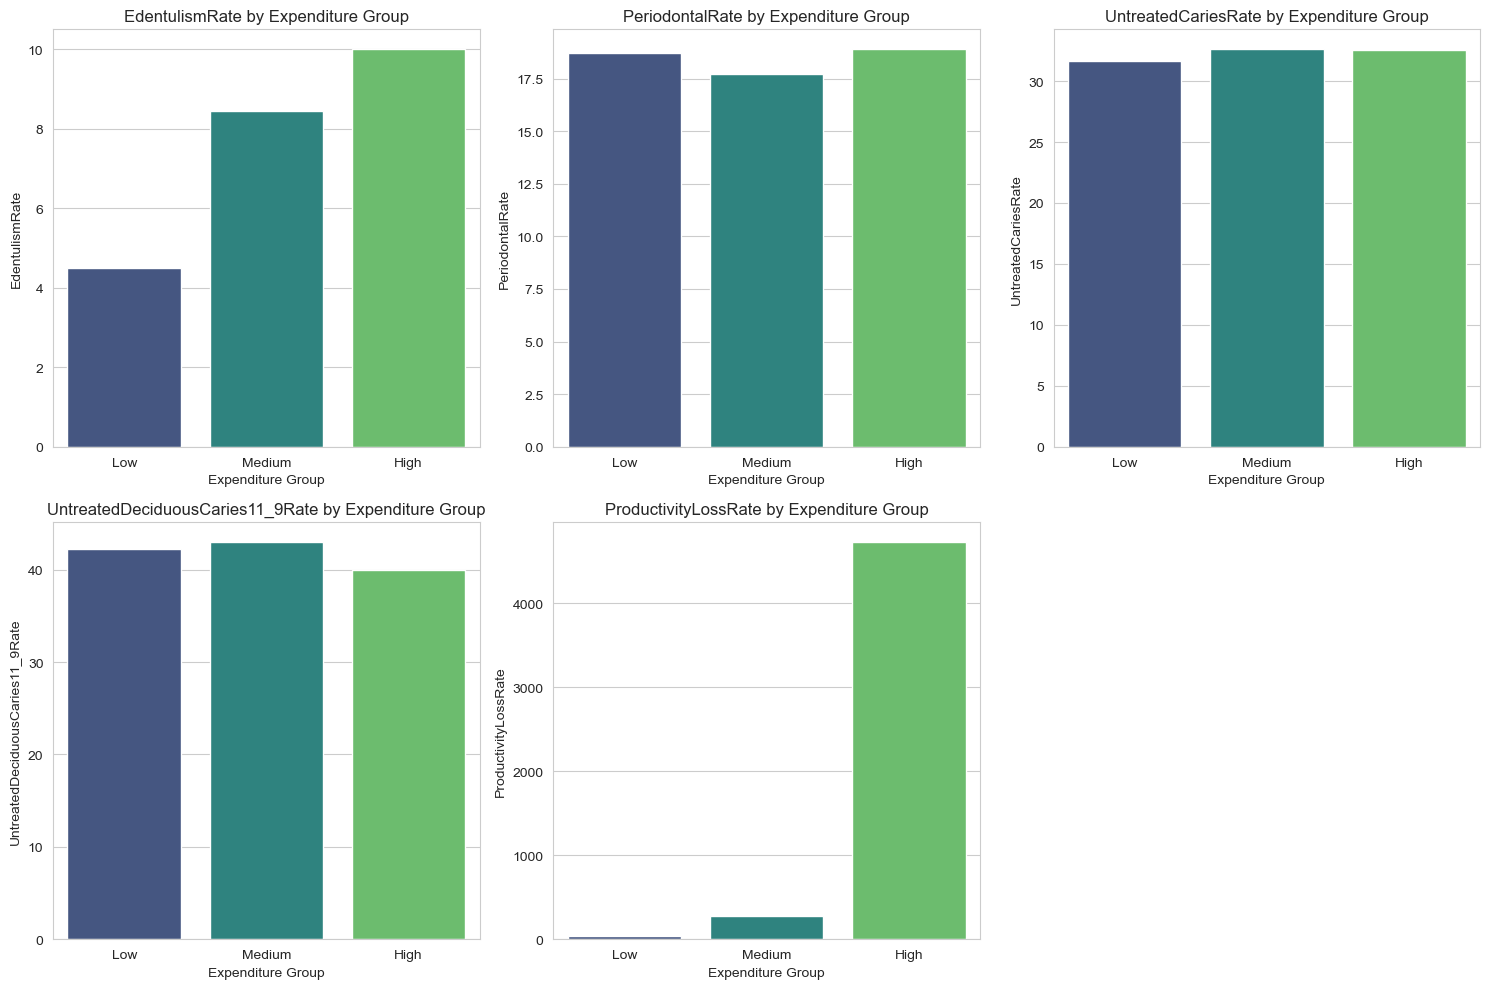

In [154]:
# Ayar: kaç sütun olsun
n_cols = 3
n_rows = (len(health_cols) + n_cols - 1) // n_cols  # Satır sayısını otomatik ayarla

# Grafik alanı
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

# axes'i her durumda düzleştir (tek subplot olsa bile listeye çevir)
if isinstance(axes, plt.Axes):
    axes = [axes]
else:
    axes = axes.flatten()

# Her gösterge için bar plot
for i, col in enumerate(health_cols):
    sns.barplot(
        x=grouped_health.index,
        y=grouped_health[col],
        palette="viridis",
        ax=axes[i]
    )
    axes[i].set_title(f"{col} by Expenditure Group")
    axes[i].set_xlabel("Expenditure Group")
    axes[i].set_ylabel(col)

# Fazla boş eksenleri kaldır (varsa)
for j in range(len(health_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


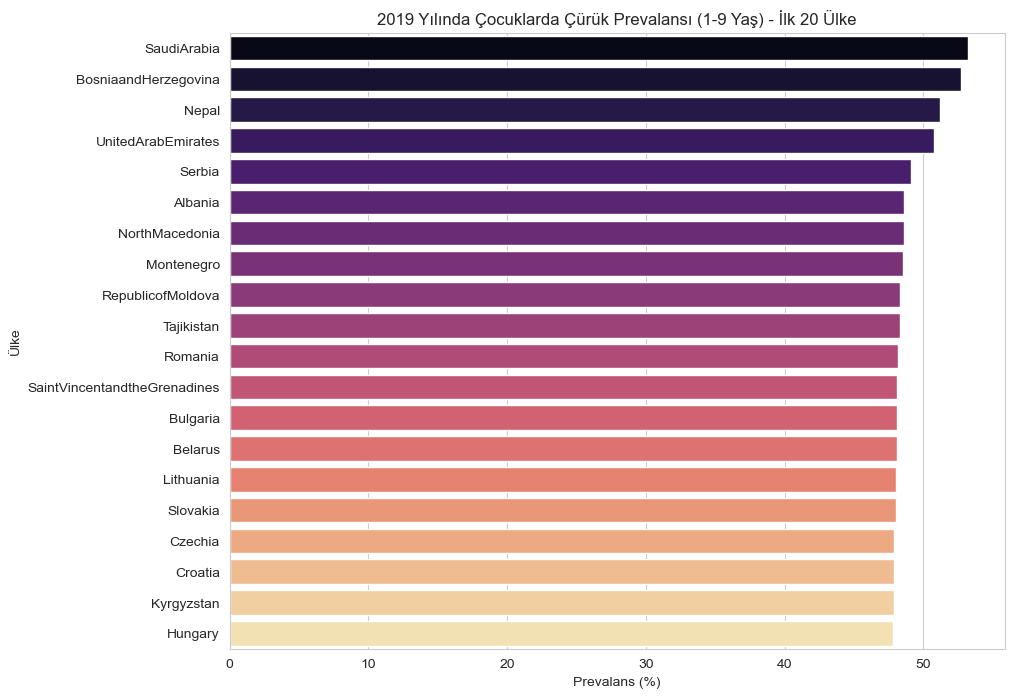

In [155]:
#2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - İlk 20 Ülke
# En yüksek 20 ülkeyi seç
top20_caries = df.nlargest(20, "UntreatedDeciduousCaries11_9Rate")

plt.figure(figsize=(10,8))
sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=top20_caries, palette="magma")
plt.title("2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - İlk 20 Ülke")
plt.xlabel("Prevalans (%)")
plt.ylabel("Ülke")
plt.show()


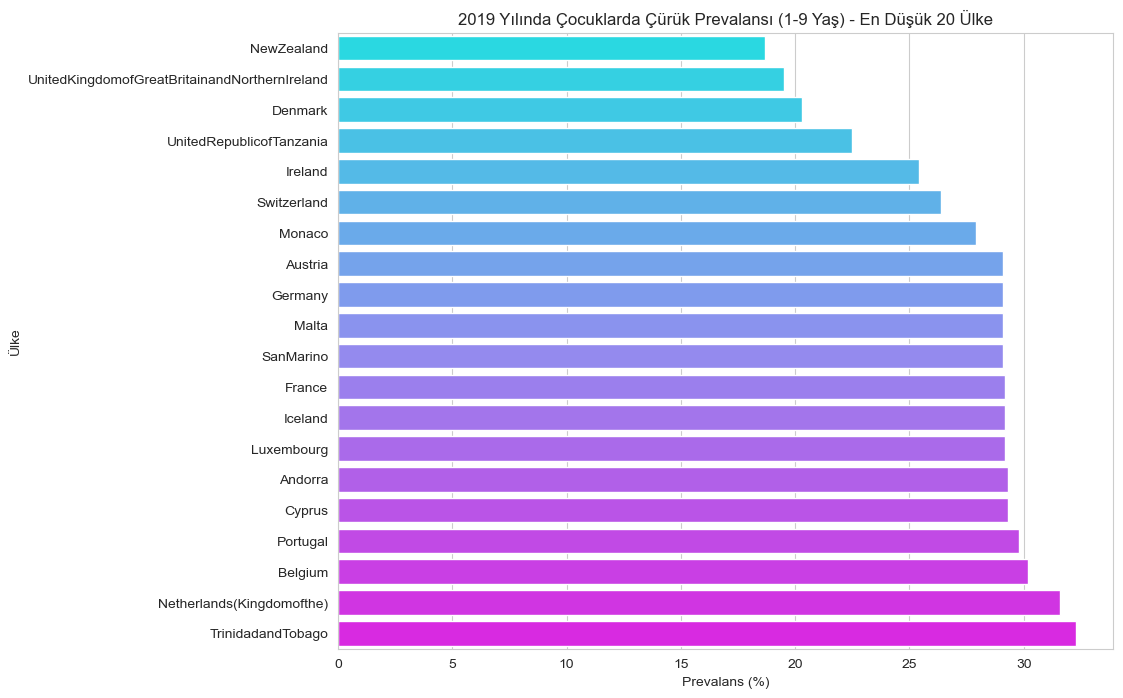

In [156]:
# En düşük 20 ülkeyi seç
bottom20_caries = df.nsmallest(20, "UntreatedDeciduousCaries11_9Rate")

plt.figure(figsize=(10,8))
sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=bottom20_caries, palette="cool")
plt.title("2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - En Düşük 20 Ülke")
plt.xlabel("Prevalans (%)")
plt.ylabel("Ülke")
plt.show()


In [157]:
countries = ["Germany", "Türkiye"]
df_countries = df[df["Location"].isin(countries)]

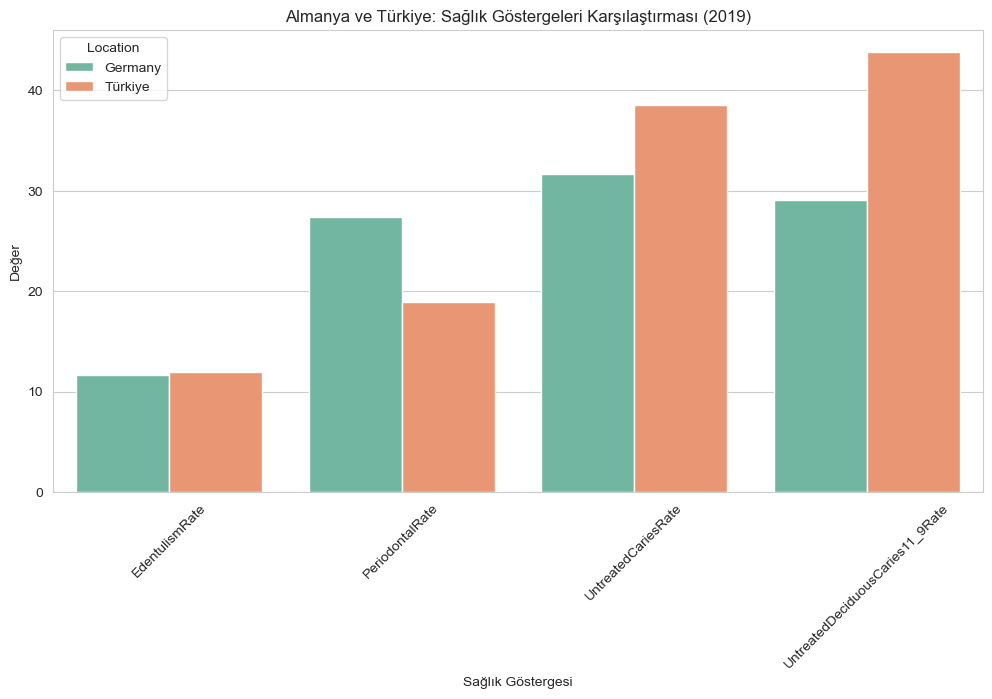

In [158]:
health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate"]

plt.figure(figsize=(12,6))
df_melted = df_countries.melt(id_vars=["Location"], value_vars=health_cols,
                              var_name="HealthIndicator", value_name="Value")

sns.barplot(x="HealthIndicator", y="Value", hue="Location", data=df_melted, palette="Set2")
plt.title("Almanya ve Türkiye: Sağlık Göstergeleri Karşılaştırması (2019)")
plt.xlabel("Sağlık Göstergesi")
plt.ylabel("Değer")
plt.xticks(rotation=45)
plt.show()


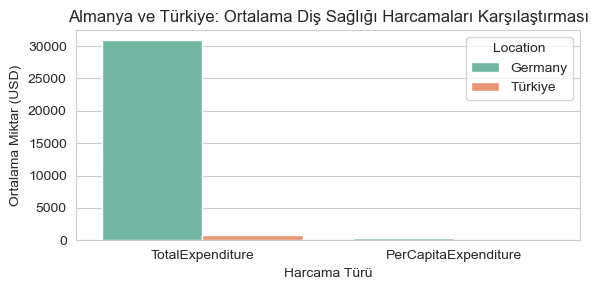

In [159]:
# Karşılaştırılacak değişkenler
expenditure_cols = ["TotalExpenditure", "PerCapitaExpenditure"]

# Almanya ve Türkiye için ortalama değerleri hesapla
df_avg = df_countries.groupby("Location")[expenditure_cols].mean().reset_index()

# Veriyi uzun formata çevir
df_avg_melted = df_avg.melt(id_vars="Location", value_vars=expenditure_cols,
                            var_name="ExpenditureType", value_name="AverageValue")

# Grafik
plt.figure(figsize=(6, 3))
sns.barplot(x="ExpenditureType", y="AverageValue", hue="Location", data=df_avg_melted, palette="Set2")

plt.title("Almanya ve Türkiye: Ortalama Diş Sağlığı Harcamaları Karşılaştırması")
plt.xlabel("Harcama Türü")
plt.ylabel("Ortalama Miktar (USD)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



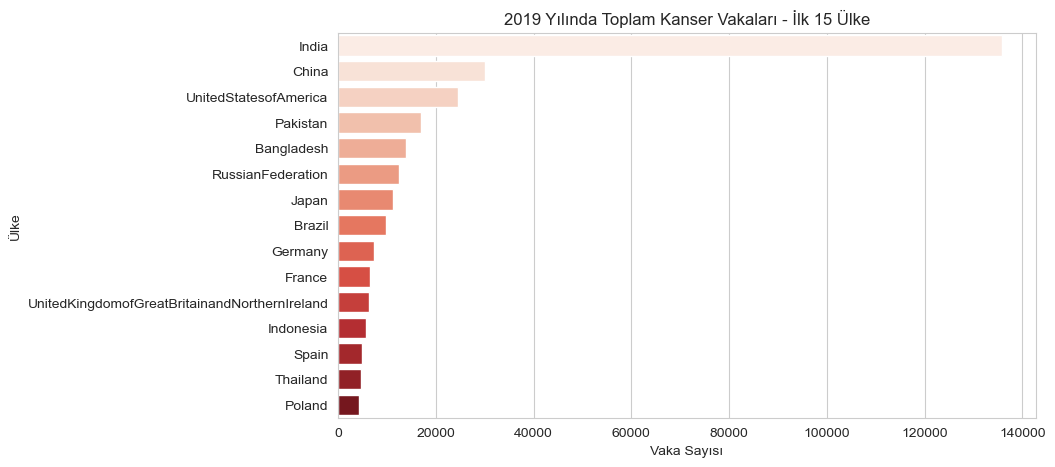

In [160]:
# Toplam kanser vaka sayısına göre ilk 15 ülke
top15_cancer = df.nlargest(15, "both_cancer")

plt.figure(figsize=(9,5))
sns.barplot(x="both_cancer", y="Location", data=top15_cancer, palette="Reds")
plt.title("2019 Yılında Toplam Kanser Vakaları - İlk 15 Ülke")
plt.xlabel("Vaka Sayısı")
plt.ylabel("Ülke")
plt.show()


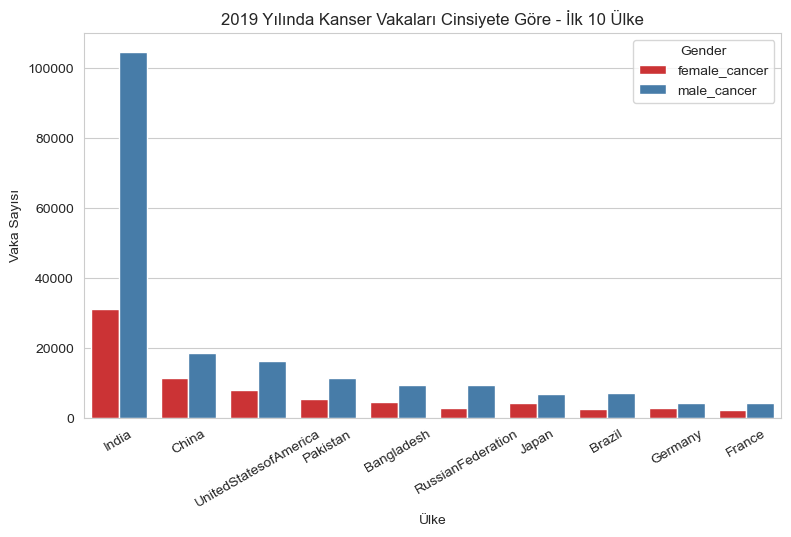

In [161]:
# Sadece ilk 10 ülke ile örnek
top10_cancer = df.nlargest(10, "both_cancer")
cancer_cols = ["female_cancer", "male_cancer"]

df_melted = top10_cancer.melt(id_vars=["Location"], value_vars=cancer_cols,
                               var_name="Gender", value_name="Cases")

plt.figure(figsize=(9,5))
sns.barplot(x="Location", y="Cases", hue="Gender", data=df_melted, palette="Set1")
plt.title("2019 Yılında Kanser Vakaları Cinsiyete Göre - İlk 10 Ülke")
plt.xlabel("Ülke")
plt.ylabel("Vaka Sayısı")
plt.xticks(rotation=30)
plt.show()


In [ ]:
#Maschine Learning Önerileri

#1️⃣ Regresyon Modelleri

#Amaç: Sürekli değerleri tahmin etmek.

#Hedef değişken (target):

#ProductivityLossRate → ağız sağlığı ile üretkenlik kaybı arasındaki ilişkiyi tahmin et

#UntreatedDeciduousCaries11_9Rate → çocuklarda çürük prevalansını tahmin et

#Özellikler (features):

#TotalExpenditure, PerCapitaExpenditure

#EdentulismRate, PeriodontalRate, UntreatedCariesRate

#both_cancer, female_cancer, male_cancer

#Kullanılabilecek modeller: Linear Regression, Random Forest, XGBoost

#2️⃣ Sınıflandırma (Classification)

#Amaç: Ülkeleri gruplara ayırmak.

#Hedef değişken:

#Harcama seviyesine göre gruplama → Low / Medium / High

#Çürük prevalansına göre sınıflandırma → Düşük / Orta / Yüksek

#Özellikler: Diğer sağlık göstergeleri, kanser vakaları, kişi başı harcama vb.

#Kullanılabilecek modeller: Logistic Regression, Random Forest, XGBoost, SVM

#3️⃣ Kümeleme (Clustering)

#Amaç: Benzer ülkeleri otomatik gruplama.

#Özellikler: Tüm sayısal göstergeler (TotalExpenditure, PerCapitaExpenditure, sağlık göstergeleri, kanser vakaları vb.)

#Kullanılacak yöntemler:

#K-Means → ülkeleri sayısal özelliklerine göre k gruba ayırır

#Hierarchical Clustering → hiyerarşik benzerlik analizi

#Görselleştirme: PCA ile 2D projeksiyon, renkler = kümeler

#4️⃣ Feature Importance Analizi

#Hangi değişkenler çocuklarda çürük, ProductivityLossRate veya kanser vakalarını en çok etkiliyor?

#Random Forest veya XGBoost kullanarak feature importance çıkarabiliriz.

#5️⃣ Örnek Pipeline

#Veriyi temizle → eksik değerleri doldur, aykırı değerleri cap’le

#Sayısal sütunları normalize / standardize et

#Hedef değişkeni seç ve features ile ayır

#Train-test split yap (örn. 80-20)

#Model seç ve eğit

#Model performansını değerlendir: RMSE, MAE (regresyon) veya Accuracy, F1-score (sınıflandırma)

#💡 Özetle:

#Regresyon → üretkenlik kaybı veya çürük oranı tahmini

#Sınıflandırma → ülkeleri sağlık veya harcama kategorilerine ayırma

#Kümeleme → benzer ülkeleri segmentleme

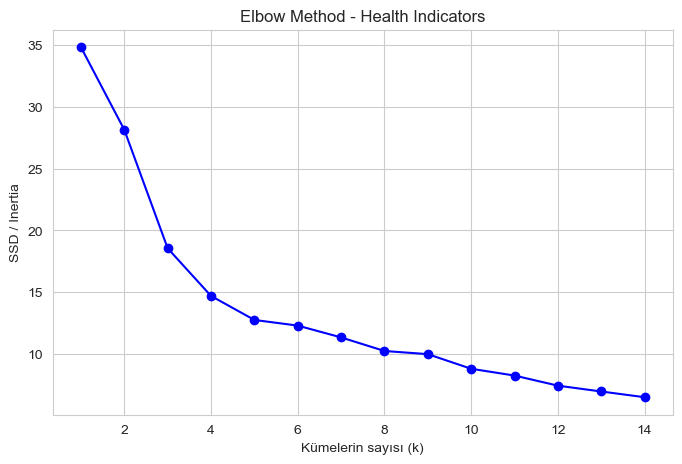

In [162]:
#Ağız Sağlığı Küme Profilleri (K-means)

health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate", "ProductivityLossRate"]

# Ölçekleme
scaler = MinMaxScaler()
X_health_scaled = scaler.fit_transform(df[health_cols])

# Elbow Method için SSD hesaplama
ssd = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_health_scaled)   # Fit et
    ssd.append(kmeans.inertia_)   # SSD'yi ekle

# Görselleştirme
plt.figure(figsize=(8,5))
plt.plot(K, ssd, 'bo-')
plt.xlabel('Kümelerin sayısı (k)')
plt.ylabel('SSD / Inertia')
plt.title('Elbow Method - Health Indicators')
plt.show()

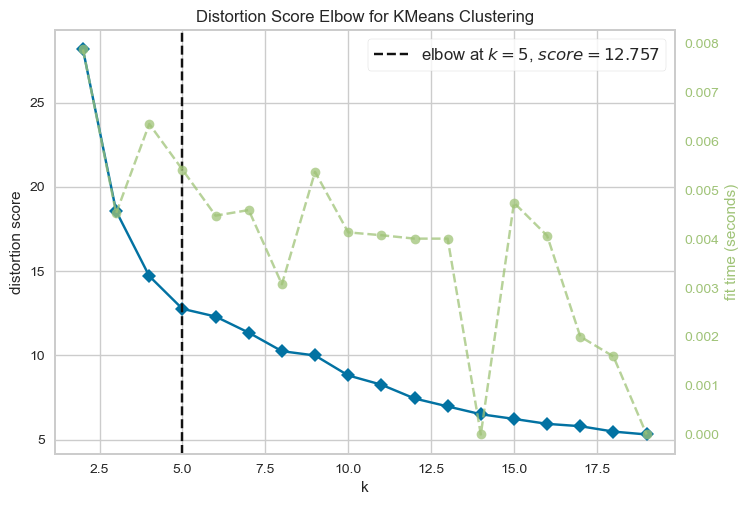

Optimal küme sayısı: 5


In [168]:
# Ölçekleme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[health_cols])

# KMeans modeli
kmeans = KMeans(random_state=42)

# K-Elbow (2-20 arasında K denemesi)
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(X_scaled) 
elbow.show()

# Optimal K
print("Optimal küme sayısı:", elbow.elbow_value_)

In [169]:
# Ölçekleme
scaler = MinMaxScaler()
X_health_scaled = scaler.fit_transform(df[health_cols])

# KMeans fit
kmeans = KMeans(n_clusters=elbow.elbow_value_,random_state=42)
kmeans.fit(X_health_scaled)

# Küme sayısı
print("Küme sayısı:", kmeans.n_clusters)

# Küme merkezleri (ölçeklenmiş değerler)
print("Küme merkezleri:\n", kmeans.cluster_centers_)

# Her verinin etiketi (hangi segmentte olduğu)
df["kmeans_cluster_no"] = kmeans.labels_ + 1

# İlk 5 satır
df.head()

Küme sayısı: 5
Küme merkezleri:
 [[0.38286713 0.61400058 0.30344203 0.714361   0.04516839]
 [0.29487179 0.17775468 0.39385037 0.76788092 0.00375052]
 [0.09722222 0.70474664 0.29408213 0.61297447 0.00336623]
 [0.6811491  0.56813865 0.36486849 0.3324745  0.04997081]
 [0.69261294 0.49496337 0.5218254  0.8005521  0.01179283]]


,Location,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer,ExpenditureGroup,kmeans_cluster_no
0,Angola,2019,70.2,2.3,4.0,23.9,27.2,37.8,195.8,482.0,166.0,316.0,Medium,3
1,Burundi,2019,1.3,0.1,2.0,19.2,31.7,41.6,5.3,92.0,30.0,62.0,Low,3
2,Benin,2019,3.3,0.3,2.9,27.1,29.5,39.6,30.0,74.0,42.0,32.0,Low,3
3,BurkinaFaso,2019,4.6,0.2,1.9,27.4,27.5,40.3,30.8,179.0,55.0,124.0,Low,3
4,Botswana,2019,57.4,24.1,7.5,26.3,32.7,37.6,59.2,60.0,8.0,52.0,Medium,1


In [170]:
# Sadece sayısal sütunlar
numeric_cols = df.select_dtypes(include=np.number).columns

# Küme bazlı özet
df.groupby("kmeans_cluster_no")[numeric_cols].agg(["count","mean","median"])

Period                 TotalExpenditure                      \
                   count    mean  median            count         mean median   
kmeans_cluster_no                                                               
1                     44  2019.0  2019.0               44  5202.229545   62.0   
2                     37  2019.0  2019.0               37   288.929730    6.9   
3                     42  2019.0  2019.0               42    10.807143    2.9   
4                     27  2019.0  2019.0               27  4781.881481  826.5   
5                     42  2019.0  2019.0               42   427.126190  123.6   

                  PerCapitaExpenditure                     EdentulismRate  \
                                 count        mean  median          count   
kmeans_cluster_no                                                           
1                                   44   57.565909   23.70             44   
2                                   37   11.605405    3.50             37   
3                                   42    0.602381    0.20             42   
4                                   27  225.388889  195.40             27   
5                                   42   35.033333   15.75             42   

                   ... both_cancer female_cancer                      \
                   ...      median         count         mean median   
kmeans_cluster_no  ...                                                 
1                  ...        92.5            38   782.894737   32.0   
2                  ...       277.0            29   255.758621  138.0   
3                  ...       166.0            41  1100.658537   55.0   
4                  ...       584.0            24   738.750000  199.0   
5                  ...       261.5            42   298.714286  101.5   

                  male_cancer                     kmeans_cluster_no       \
                        count         mean median             count mean   
kmeans_cluster_no                                                          
1                          38  1308.210526   53.5                44  1.0   
2                          29   483.379310  126.0                37  2.0   
3                          41  3179.951220   74.0                42  3.0   
4                          24  1209.166667  354.0                27  4.0   
5                          42   808.095238  178.0                42  5.0   

                          
                  median  
kmeans_cluster_no         
1                    1.0  
2                    2.0  
3                    3.0  
4                    4.0  
5                    5.0  

[5 rows x 36 columns]

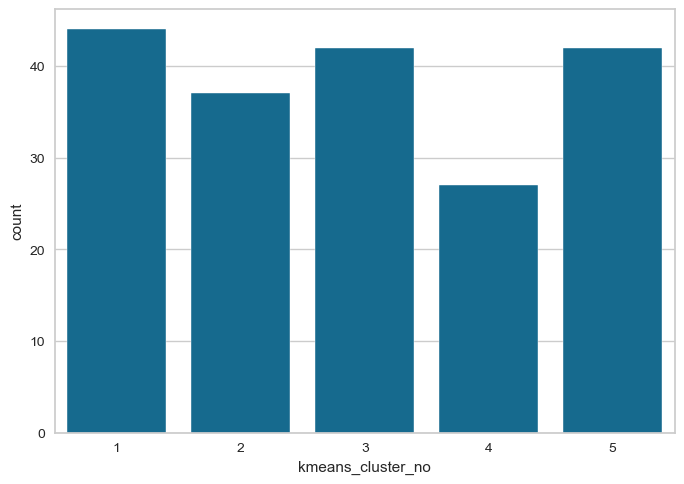

In [171]:
df["kmeans_cluster_no"].value_counts()
sns.countplot(x="kmeans_cluster_no", data=df)
plt.show()

In [172]:
# Küme bazında ülkeler
cluster_countries = df.groupby("kmeans_cluster_no")["Location"].apply(list)
cluster_countries

kmeans_cluster_no
1    [Botswana, CentralAfricanRepublic, Lesotho, Es...
2    [Mauritius, SierraLeone, Seychelles, Afghanist...
3    [Angola, Burundi, Benin, BurkinaFaso, Coted'Iv...
4    [Namibia, Colombia, TrinidadandTobago, Andorra...
5    [Algeria, Bolivia(PlurinationalStateof), Brazi...
Name: Location, dtype: object

In [173]:
# Küme bazında ortalama değerler
cluster_means = df.groupby("kmeans_cluster_no")[numeric_cols].mean()
cluster_means

,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer,kmeans_cluster_no
kmeans_cluster_no,,,,,,,,,,,,
1,2019.0,5202.229545,57.565909,7.172727,21.456818,30.275000,43.345455,3544.390909,2091.105263,782.894737,1308.210526,1.0
2,2019.0,288.929730,11.605405,5.800000,7.845946,32.770270,45.191892,294.397297,739.137931,255.758621,483.379310,2.0
3,2019.0,10.807143,0.602381,2.716667,24.288095,30.016667,39.847619,264.242857,4280.609756,1100.658537,3179.951220,3.0
4,2019.0,4781.881481,225.388889,11.825926,20.025926,31.970370,30.170370,3921.229630,1947.916667,738.750000,1209.166667,4.0
5,2019.0,427.126190,35.033333,12.004762,17.742857,36.302381,46.319048,925.464286,1106.809524,298.714286,808.095238,5.0


In [174]:
# Her kümedeki ülkeleri listele
clusters_countries = df.groupby("kmeans_cluster_no")["Location"].apply(list)

# Her kümeyi tek tek yazdıralım
for cluster, countries in clusters_countries.items():
    print(f"\n📌 Küme {cluster} ({len(countries)} ülke):")
    print(", ".join(countries))


📌 Küme 1 (44 ülke):
Botswana, CentralAfricanRepublic, Lesotho, Eswatini, SouthAfrica, Zimbabwe, Argentina, AntiguaandBarbuda, Bahamas, Belize, Barbados, Canada, CostaRica, Dominica, DominicanRepublic, Grenada, Guatemala, Guyana, Honduras, Haiti, Jamaica, SaintKittsandNevis, SaintLucia, Mexico, Nicaragua, Panama, Paraguay, ElSalvador, Suriname, UnitedStatesofAmerica, SaintVincentandtheGrenadines, Venezuela(BolivarianRepublicof), UnitedArabEmirates, Bahrain, Egypt, Iran(IslamicRepublicof), Kuwait, Libya, Qatar, Indonesia, Thailand, China, RepublicofKorea, Singapore

📌 Küme 2 (37 ülke):
Mauritius, SierraLeone, Seychelles, Afghanistan, Iraq, Jordan, Oman, SaudiArabia, Sudan, Yemen, Spain, Tajikistan, Uzbekistan, SriLanka, Maldives, Myanmar, Nepal, DemocraticPeople'sRepublicofKorea, Timor-Leste, BruneiDarussalam, Fiji, Micronesia(FederatedStatesof), Cambodia, Kiribati, LaoPeople'sDemocraticRepublic, MarshallIslands, Malaysia, Nauru, Philippines, Palau, PapuaNewGuinea, SolomonIslands, Tonga

📌 Küme 1 (44 ülke)

Ülkeler: Afrika’nın güneyi (Botswana, Güney Afrika, Zimbabve), Kuzey Afrika’dan bazı ülkeler (Mısır, Libya), Kuzey Amerika (ABD, Kanada, Meksika), Orta Amerika ve Karayipler (Dominik, Jamaika, Küba hariç birçok ada ülkesi), Güney Amerika’dan Arjantin, Venezuela, Paraguay, Asya’dan Çin, Kore, Endonezya, Tayland, Singapur, Körfez ülkeleri (BAE, Katar, Kuveyt, Bahreyn).

Genel Özellik:

Yüksek sağlık harcamaları, görece daha iyi ağız sağlığı, güçlü ekonomi ve sağlık altyapısı.

ABD, Kanada, Singapur, Çin gibi yüksek gelirli ülkeler ile bazı petrol zengini Orta Doğu ülkeleri aynı kümeye düşmüş.

Küme 1 (ABD, Çin, Körfez, vs.)

Çok yüksek sağlık harcaması (5202), ama kişi başı düşük (57.6) → büyük nüfuslu ülkeler (Çin, ABD).

Ağız sağlığı orta düzeyde (Edentulism %7.1).

Kanser yükü yüksek (2091).

📌 Küme 2 (37 ülke)

Ülkeler: Güney Asya (Afganistan, Nepal, Sri Lanka), Orta Asya (Tacikistan, Özbekistan), Ortadoğu (Irak, Yemen, Suudi Arabistan), Güneydoğu Asya ve Pasifik ülkeleri (Malezya, Filipinler, Fiji, Vietnam).

Genel Özellik:

Orta gelir grubu, sağlık göstergeleri ve harcama seviyeleri orta seviyede.

Sağlık sistemleri gelişmekte, ancak bölgesel eşitsizlikler mevcut.

Küme 2 (Ortadoğu + Pasifik + Asya gelişmekte)

Düşük harcama (289 toplam, kişi başı 11.6).

Ağız sağlığı görece iyi (Edentulism %5.8, Periodontal %7.8).

Kanser yükü düşük (739).

📌 Küme 3 (42 ülke)

Ülkeler: Büyük oranda Afrika ülkeleri (Kenya, Nijerya, Tanzanya, Etiyopya, Senegal, vs.), ayrıca Pakistan, Hindistan, Bangladeş, Bhutan.

Genel Özellik:

Düşük sağlık harcaması, ağız sağlığı sorunları daha yüksek.

Gelişmekte olan ve düşük gelirli ülkeler.

En kırılgan grup diyebiliriz.

Küme 3 (Afrika + Hindistan, Pakistan)

Çok düşük harcama (10.8 toplam, kişi başı 0.6).

Edentulism düşük (%2.7) ama bu sağlık hizmeti yetersizliğinden olabilir (raporlanmamış vaka olasılığı).

Periodontal çok yüksek (%24) → ciddi sorun.

Kanser yükü çok yüksek (4280, erkeklerde 3180!) → sağlık hizmetlerine erişim düşük.

📌 Küme 4 (27 ülke)

Ülkeler: Avrupa Birliği ve Batı Avrupa ülkeleri (Almanya, Fransa, İtalya, İskandinav ülkeleri, Benelüks), ayrıca Avustralya, Japonya, Yeni Zelanda.

Genel Özellik:

En gelişmiş sağlık sistemleri, yüksek kişi başı sağlık harcaması.

Ağız sağlığı göstergeleri en iyi seviyede.

Bu küme aslında yüksek gelirli OECD ülkeleri kümesi.

Küme 4 (Batı Avrupa + OECD)

Çok yüksek harcama (4781, kişi başı 225).

Edentulism en yüksek (%11.8) → yaşlı nüfus etkisi.

Kanser yükü orta (1947).

Sağlık sistemi güçlü ama yaşlanma kaynaklı ağız sağlığı sorunları artıyor.

📌 Küme 5 (42 ülke)

Ülkeler: Doğu Avrupa (Rusya, Ukrayna, Polonya, Romanya, Balkan ülkeleri), Kuzey Afrika (Cezayir, Tunus, Fas), Latin Amerika (Brezilya, Şili, Peru, Uruguay), Türkiye, İsrail, İsveç, Kazakistan.

Genel Özellik:

Orta-yüksek harcama düzeyi, ağız sağlığı bazı alanlarda iyi ama batı ülkeleri kadar değil.

Geçiş ekonomileri ve “orta-üst gelir” ülkeleri diyebiliriz.

Küme 5 (Doğu Avrupa + Latin Amerika + Türkiye)

Orta harcama (427 toplam, kişi başı 35).

Edentulism yüksek (%12) → ağız sağlığı zayıf.

Periodontal ve caries oranları yüksek.

Kanser yükü orta (1106).

Küme 3: En düşük gelişmişlik (Afrika + Güney Asya)

Küme 2: Orta gelişmişlik (Ortadoğu + Güneydoğu Asya + Pasifik)

Küme 5: Orta-üst gelişmişlik (Doğu Avrupa + Latin Amerika + Türkiye)

Küme 1: Yüksek gelişmişlik (ABD, Kanada, Çin, petrol zengini Orta Doğu, bazı Latin Amerika ülkeleri)

Küme 4: En yüksek gelişmişlik (Batı Avrupa + OECD ülkeleri)

En fakir küme: Küme 3 (Afrika + Güney Asya)

En zengin küme: Küme 4 (OECD ülkeleri)

Geçiş ülkeleri: Küme 5 (Doğu Avrupa, Türkiye, Latin Amerika)

Özel karışık grup: Küme 1 (ABD, Çin, petrol zengini ülkeler)

Orta gelişmişlik: Küme 2 (Ortadoğu + Pasifik ülkeleri)


Karşılaştırma:
                                   Germany  Cluster_Avg
Period                             2019.0  2019.000000
TotalExpenditure                  30877.3  4781.881481
PerCapitaExpenditure                372.2   225.388889
EdentulismRate                       11.7    11.825926
PeriodontalRate                      27.4    20.025926
UntreatedCariesRate                  31.7    31.970370
UntreatedDeciduousCaries11_9Rate     29.1    30.170370
ProductivityLossRate              19395.9  3921.229630
both_cancer                        7333.0  1947.916667
female_cancer                      2855.0   738.750000
male_cancer                        4478.0  1209.166667


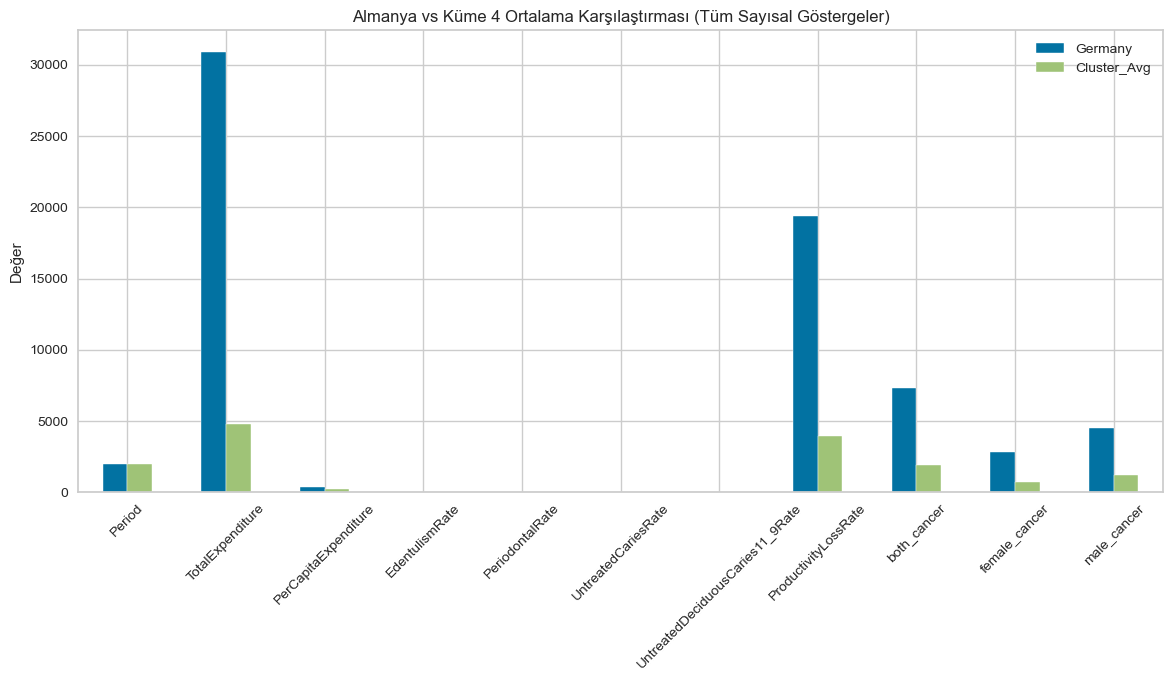

In [175]:
# Tüm sayısal sütunlar
numerical_cols = df.select_dtypes(include="number").columns.tolist()
numerical_cols.remove("kmeans_cluster_no")  # Küme etiketi karşılaştırmaya dahil olmasın

# Almanya'nın değerleri
germany_values = df[df["Location"] == "Germany"][numerical_cols]

# Almanya'nın küme numarası
germany_cluster = df[df["Location"] == "Germany"]["kmeans_cluster_no"].values[0]

# Küme ortalamaları
cluster_mean = df[df["kmeans_cluster_no"] == germany_cluster][numerical_cols].mean()

# Karşılaştırma tablosu
comparison = pd.DataFrame({
    "Germany": germany_values.values.flatten(),
    "Cluster_Avg": cluster_mean.values
}, index=numerical_cols)

print("\nKarşılaştırma:\n", comparison)

# Görselleştirme - Barplot
comparison.plot(kind="bar", figsize=(14,6))
plt.title(f"Almanya vs Küme {germany_cluster} Ortalama Karşılaştırması (Tüm Sayısal Göstergeler)")
plt.ylabel("Değer")
plt.xticks(rotation=45)
plt.show()

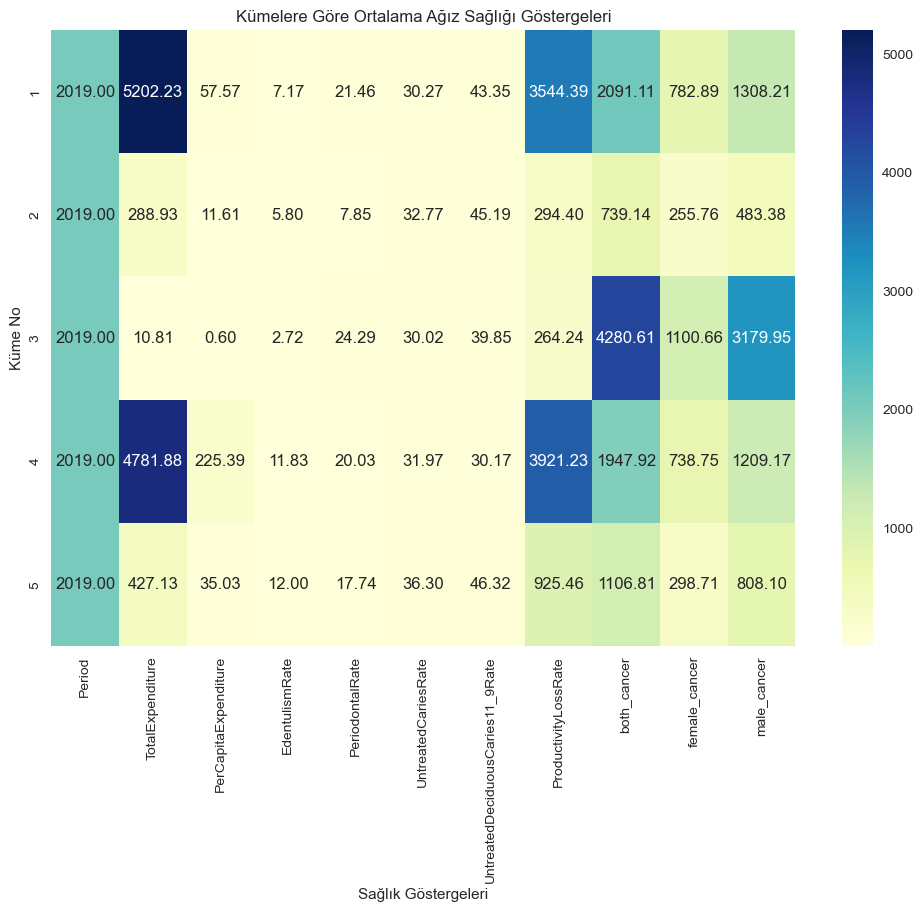

In [176]:
# Sadece sayısal sütunlar
num_cols = df.select_dtypes(include='number').columns.drop('kmeans_cluster_no')

# Küme bazında ortalamalar
cluster_means_health = df.groupby("kmeans_cluster_no")[num_cols].mean()

# Heatmap görselleştirme
plt.figure(figsize=(12,8))
sns.heatmap(cluster_means_health, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Kümelere Göre Ortalama Ağız Sağlığı Göstergeleri")
plt.xlabel("Sağlık Göstergeleri")
plt.ylabel("Küme No")
plt.show()

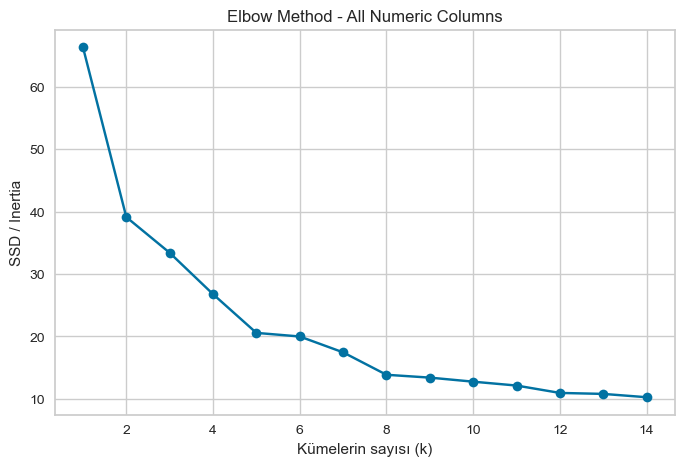

In [177]:
#Agiz kanseri dahil Kmeans kümeleme (eksik deger satirlari silindi)

# Tüm sayısal sütunları seç
numeric_cols = df.select_dtypes(include=np.number).columns

# NaN değerleri temizle
df_numeric = df[numeric_cols].dropna()

# Ölçekleme
scaler = MinMaxScaler()
Xall_scaled = scaler.fit_transform(df_numeric)

# Elbow Method için SSD hesaplama
ssd = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Xall_scaled)
    ssd.append(kmeans.inertia_)

# Görselleştirme
plt.figure(figsize=(8,5))
plt.plot(K, ssd, 'bo-')
plt.xlabel('Kümelerin sayısı (k)')
plt.ylabel('SSD / Inertia')
plt.title('Elbow Method - All Numeric Columns')
plt.show()

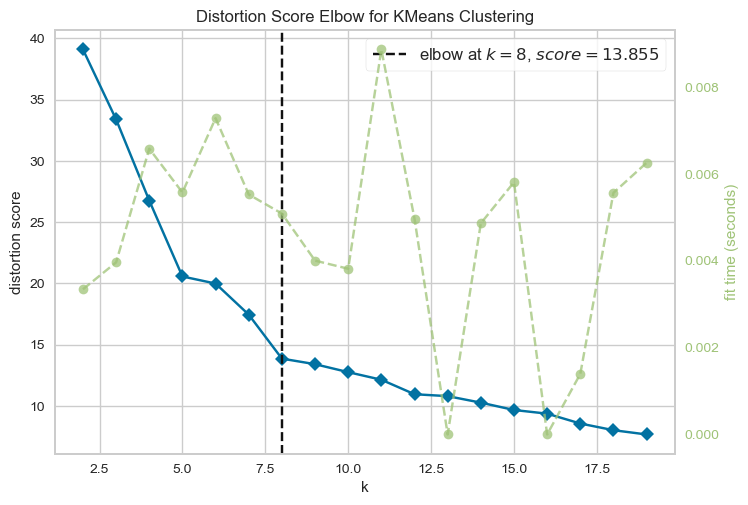

Optimal küme sayısı: 8


In [178]:
# Ölçekleme
scaler = MinMaxScaler()
Xall_scaled = scaler.fit_transform(df_numeric)

# KMeans modeli
kmeans = KMeans(random_state=42)

# K-Elbow (2-20 arasında K denemesi)
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(Xall_scaled)
elbow.show()

# Optimal K
print("Optimal küme sayısı:", elbow.elbow_value_)

In [179]:
# Ölçekleme
scaler = MinMaxScaler()
Xall_scaled = scaler.fit_transform(df_numeric)

# KMeans fit
kmeans = KMeans(n_clusters=elbow.elbow_value_, random_state=42)
kmeans.fit(Xall_scaled)

# Küme sayısı
print("Küme sayısı:", kmeans.n_clusters)

# Küme merkezleri (ölçeklenmiş değerler)
print("Küme merkezleri:\n", kmeans.cluster_centers_)

# Her verinin etiketi (hangi segmentte olduğu)
df_numeric["kmeans_cluster_no"] = kmeans.labels_ + 1

# İlk 5 satır
df_numeric.head()

Küme sayısı: 8
Küme merkezleri:
 [[0.00000000e+00 1.93069454e-02 1.00896002e-01 3.76992377e-01
  6.03170478e-01 3.09341951e-01 7.06071289e-01 2.66587528e-02
  1.09196133e-02 1.87567637e-02 8.58765320e-03 1.11022302e-16]
 [0.00000000e+00 1.62761583e-02 1.78466319e-01 6.67652860e-01
  5.13313609e-01 3.96599777e-01 3.30434783e-01 3.12985874e-02
  9.56225938e-03 1.56857342e-02 7.74228638e-03 7.69230769e-01]
 [0.00000000e+00 7.28994546e-05 1.19926199e-03 9.48717949e-02
  7.02884615e-01 2.95108696e-01 6.11086957e-01 1.20445845e-03
  7.26419328e-03 1.10808174e-02 6.13343207e-03 5.00000000e-01]
 [0.00000000e+00 2.75992142e-03 2.26692830e-02 2.88019452e-01
  2.10764810e-01 3.76436782e-01 7.57921039e-01 4.76173275e-03
  5.42304274e-03 8.17956443e-03 4.60901309e-03 2.50000000e-01]
 [0.00000000e+00 2.38497129e-03 4.57661682e-02 6.95512821e-01
  4.94551282e-01 5.23097826e-01 8.11666667e-01 1.12264359e-02
  8.37122132e-03 9.67522707e-03 7.99111408e-03 1.00000000e+00]
 [0.00000000e+00 6.10802619e-02 

,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer,kmeans_cluster_no
0,2019,70.2,2.3,4.0,23.9,27.2,37.8,195.8,482.0,166.0,316.0,3
1,2019,1.3,0.1,2.0,19.2,31.7,41.6,5.3,92.0,30.0,62.0,3
2,2019,3.3,0.3,2.9,27.1,29.5,39.6,30.0,74.0,42.0,32.0,3
3,2019,4.6,0.2,1.9,27.4,27.5,40.3,30.8,179.0,55.0,124.0,3
4,2019,57.4,24.1,7.5,26.3,32.7,37.6,59.2,60.0,8.0,52.0,1


In [180]:
# Küme bazlı özet (sayısal sütunlar)
numeric_cols = df_numeric.select_dtypes(include=np.number).columns

cluster_summary = df_numeric.groupby("kmeans_cluster_no")[numeric_cols].agg(["count", "mean", "median"])

# Göster
cluster_summary

Period                 TotalExpenditure                 \
                   count    mean  median            count           mean   
kmeans_cluster_no                                                          
1                     37  2019.0  2019.0               37    2577.589189   
2                     13  2019.0  2019.0               13    2172.961538   
3                     40  2019.0  2019.0               40       9.732500   
4                     29  2019.0  2019.0               29     368.465517   
5                     40  2019.0  2019.0               40     318.407500   
6                     13  2019.0  2019.0               13    8154.569231   
7                      1  2019.0  2019.0                1  133505.800000   
8                      1  2019.0  2019.0                1      64.500000   

                             PerCapitaExpenditure                     \
                      median                count        mean median   
kmeans_cluster_no                                                      
1                      82.30                   37   51.951351   16.7   
2                     593.70                   13   91.892308   91.6   
3                       2.90                   40    0.617500    0.2   
4                      16.70                   29   11.672414    3.1   
5                     117.25                   40   23.565000   15.5   
6                    3375.80                   13  318.492308  321.7   
7                  133505.80                    1  405.500000  405.5   
8                      64.50                    1    0.000000    0.0   

                  EdentulismRate  ... both_cancer female_cancer                \
                           count  ...      median         count          mean   
kmeans_cluster_no                 ...                                           
1                             37  ...        89.0            37    586.486486   
2                             13  ...       317.0            13    490.461538   
3                             40  ...       144.5            40    346.475000   
4                             29  ...       277.0            29    255.758621   
5                             40  ...       261.5            40    302.525000   
6                             13  ...       695.0            13    907.615385   
7                              1  ...     24470.0             1   8050.000000   
8                              1  ...    135929.0             1  31268.000000   

                           male_cancer                           \
                    median       count           mean    median   
kmeans_cluster_no                                                 
1                     32.0          37     899.783784      53.0   
2                    115.0          13     811.307692     208.0   
3                     54.0          40     642.925000      74.0   
4                    138.0          29     483.379310     126.0   
5                     92.5          40     837.350000     178.0   
6                    331.0          13    1455.307692     471.0   
7                   8050.0           1   16420.000000   16420.0   
8                  31268.0           1  104661.000000  104661.0   

                  kmeans_cluster_no              
                              count mean median  
kmeans_cluster_no                                
1                                37  1.0    1.0  
2                                13  2.0    2.0  
3                                40  3.0    3.0  
4                                29  4.0    4.0  
5                                40  5.0    5.0  
6                                13  6.0    6.0  
7                                 1  7.0    7.0  
8                                 1  8.0    8.0  

[8 rows x 36 columns]

In [181]:
# Eğer df_numeric sadece sayısalları içeriyorsa
df_numeric["Location"] = df["Location"]
clusters_countries = df_numeric.groupby("kmeans_cluster_no")["Location"].apply(list)

for cluster, countries in clusters_countries.items():
    print(f"\n📌 Küme {cluster} ({len(countries)} ülke):")
    print(", ".join(countries))


📌 Küme 1 (37 ülke):
Botswana, CentralAfricanRepublic, Lesotho, Eswatini, SouthAfrica, Zimbabwe, Argentina, Bahamas, Barbados, Canada, CostaRica, DominicanRepublic, Guatemala, Guyana, Honduras, Haiti, Jamaica, SaintLucia, Mexico, Nicaragua, Panama, Paraguay, ElSalvador, Suriname, Venezuela(BolivarianRepublicof), UnitedArabEmirates, Bahrain, Egypt, Iran(IslamicRepublicof), Kuwait, Libya, Qatar, Indonesia, Thailand, China, RepublicofKorea, Singapore

📌 Küme 2 (13 ülke):
Namibia, Colombia, TrinidadandTobago, Cyprus, Finland, France, UnitedKingdomofGreatBritainandNorthernIreland, Greece, Ireland, Israel, Malta, Portugal, NewZealand

📌 Küme 3 (40 ülke):
Angola, Burundi, Benin, BurkinaFaso, Coted'Ivoire, Cameroon, DemocraticRepublicoftheCongo, Congo, Comoros, CaboVerde, Eritrea, Ethiopia, Gabon, Ghana, Guinea, Gambia, Guinea-Bissau, EquatorialGuinea, Kenya, Liberia, Madagascar, Mali, Mozambique, Mauritania, Malawi, Niger, Nigeria, Rwanda, Senegal, SouthSudan, Chad, Togo, UnitedRepublicofTanz

📌Küme 1 (37 ülke)

Çoğunluk Afrika ve bazı Orta-Amerika ülkeleri.

Orta-düşük toplam harcama ve kişi başı harcama olasılığı yüksek.

Toplam harcama: 2577 ortalama

Kişi başı harcama: 51.95

Üretkenlik kaybı ve ağız sağlığı oranları: orta seviyede

Kanser vakaları: düşük-orta

Bu küme çoğunlukla orta gelirli ülkeler olabilir.

📌Küme 2 (13 ülke)

Avrupa’nın bazı refah düzeyi yüksek ülkeleri (İsviçre, Finland, İngiltere vb.)

Yüksek ağız sağlığı göstergeleri ve harcama ortalaması daha iyi olabilir.

Toplam harcama: 2172 ortalama

Kişi başı harcama: 91.9 (Küme 1’den yüksek)

Ağız sağlığı göstergeleri yüksek

Kanser vakaları orta seviyede

Avrupa’nın refah seviyesi orta-üst ülkeleri gibi görünüyor.

📌Küme 3 (40 ülke)

Afrika’nın düşük gelirli ülkeleri ağırlıklı.

Ağız sağlığı göstergelerinde sorunlu, harcamada düşük.

Toplam harcama çok düşük: 9.7

Kişi başı harcama 0.6 → ciddi düşük gelir

Ağız sağlığı göstergeleri kötü değil ama düşük harcama dikkat çekici

Kanser vakaları düşük → demografik ve raporlama etkisi olabilir.

📌Küme 4 (29 ülke)

Orta Doğu ve Güneydoğu Asya ülkeleri, gelişmekte olan ülkeler karışık.

Harcama ve sağlık göstergeleri karışık.

📌Küme 5 (40 ülke)

Güney Amerika ve Doğu Avrupa ağırlıklı.

Harcama ve sağlık göstergelerinde orta seviyeler.

(küme 4 ve küme 5 Orta harcama ve kişi başı harcama Ağız sağlığı ve kanser vakaları değişken

Muhtemelen gelişmekte olan ülkeler veya karışık gelir grubu)

📌Küme 6 (13 ülke)

Almanya, İsveç, Avusturya gibi zengin ülkeler + gelişmiş ülkeler.

Yüksek toplam ve kişi başı harcama, iyi ağız sağlığı göstergeleri.

Toplam ve kişi başı harcama yüksek (8154 ve 318 kişi başı)

Kanser vakaları orta-yüksek

Refah seviyesi yüksek ülkeler

📌Küme 7 (1 ülke)

ABD tek başına bir küme oluşturmuş.

Toplam ve kişi başı harcama çok yüksek

Kanser vakaları da çok yüksek

Büyük toplam harcama ama kişi başına değişkenlik gösterebilir.

Tek başına küme oluşması nüfus ve harcama etkisinden kaynaklanıyor.

📌Küme 8 (1 ülke)

Hindistan tek başına.

Çok büyük nüfus ve düşük kişi başı harcama nedeniyle ayrı küme.

Toplam harcama düşük, kişi başı harcama çok düşük

Kanser vakaları nüfus etkisiyle çok yüksek

Bu da nüfus büyüklüğü ve düşük kişi başı harcama etkisi.



🔹 Analiz Yorumları

Kümeleme, gelir ve sağlık göstergeleri ile coğrafi dağılımı birleştiriyor gibi.

Küme 6 Almanya dahil, yüksek harcama ve iyi sağlık göstergeleri ile zengin ülkeleri temsil ediyor.

Küme 1 ve 3, düşük gelir ve düşük sağlık göstergeleri olan ülkeleri temsil ediyor.

ABD ve Hindistan gibi nüfus etkisi çok yüksek ülkeler, tek başlarına ayrı küme oluşturmuş.

🔹 Genel Yorumlar

Harcamalar ve sağlık göstergeleri kümeleme için güçlü etken.

Nüfus etkisi (ABD, Hindistan) tekil kümeler oluşturuyor.

Avrupa ve yüksek gelirli ülkeler kendi küçük kümelerinde toplanmış (küme 6).

Düşük gelirli Afrika ve bazı Asya ülkeleri küme 3’te toplanmış.


Karşılaştırma:
                                   Germany  Cluster_Avg
Period                             2019.0  2019.000000
TotalExpenditure                  30877.3  8154.569231
PerCapitaExpenditure                372.2   318.492308
EdentulismRate                       11.7    12.138462
PeriodontalRate                      27.4    21.246154
UntreatedCariesRate                  31.7    31.707692
UntreatedDeciduousCaries11_9Rate     29.1    31.869231
ProductivityLossRate              19395.9  5956.630769
both_cancer                        7333.0  2362.923077
female_cancer                      2855.0   907.615385
male_cancer                        4478.0  1455.307692


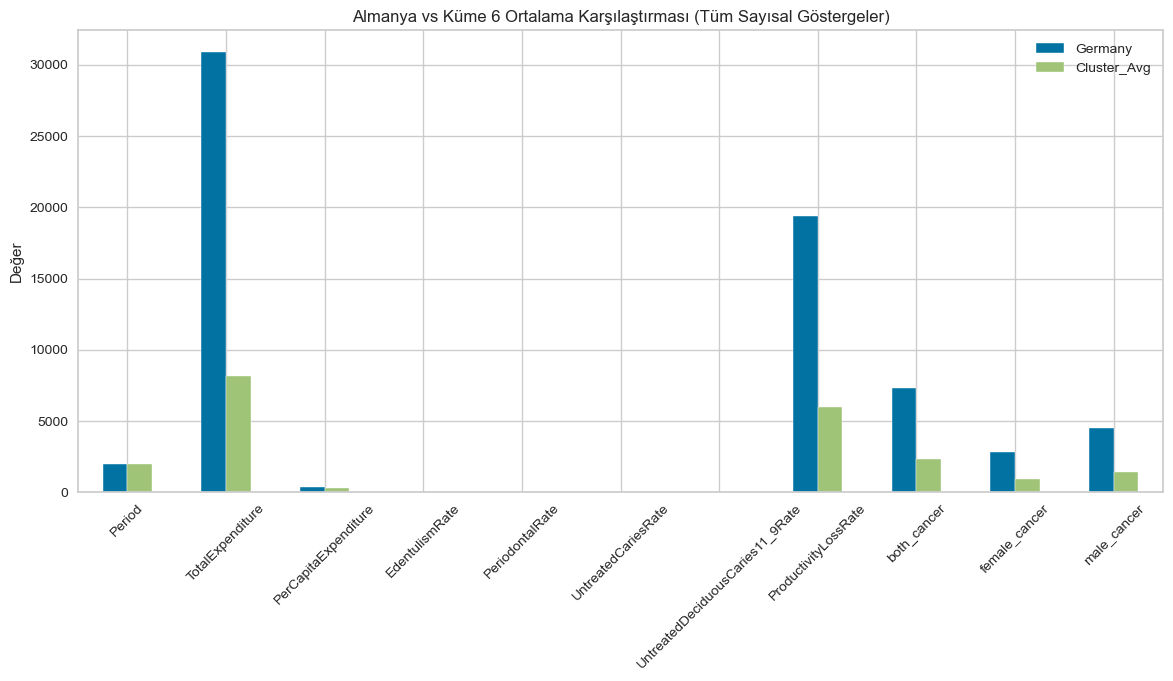

In [182]:
# Tüm sayısal sütunlar
numerical_cols = df_numeric.select_dtypes(include="number").columns.tolist()
numerical_cols.remove("kmeans_cluster_no")  # Küme etiketi karşılaştırmaya dahil olmasın

# Almanya'nın değerleri
germany_values = df_numeric[df_numeric["Location"] == "Germany"][numerical_cols]

# Almanya'nın küme numarası
germany_cluster = df_numeric[df_numeric["Location"] == "Germany"]["kmeans_cluster_no"].values[0]

# Küme ortalamaları
cluster_mean = df_numeric[df_numeric["kmeans_cluster_no"] == germany_cluster][numerical_cols].mean()

# Karşılaştırma tablosu
comparison = pd.DataFrame({
    "Germany": germany_values.values.flatten(),
    "Cluster_Avg": cluster_mean.values
}, index=numerical_cols)

print("\nKarşılaştırma:\n", comparison)

# Görselleştirme - Barplot
comparison.plot(kind="bar", figsize=(14,6))
plt.title(f"Almanya vs Küme {germany_cluster} Ortalama Karşılaştırması (Tüm Sayısal Göstergeler)")
plt.ylabel("Değer")
plt.xticks(rotation=45)
plt.show()

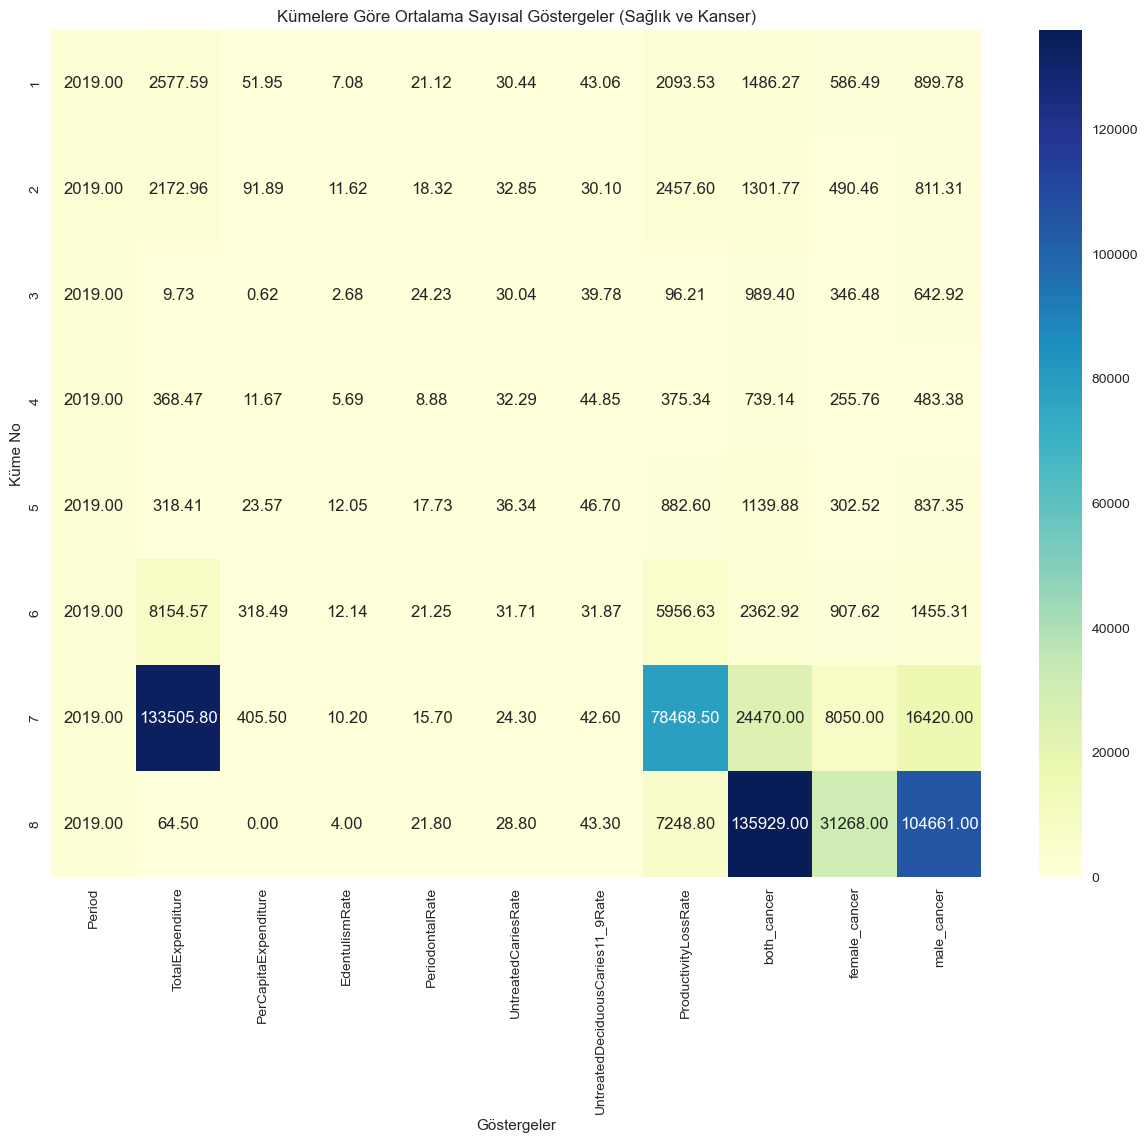

In [183]:
# Sadece sayısal sütunlar
numeric_cols = df_numeric.select_dtypes(include='number').columns.drop('kmeans_cluster_no')

# Küme bazında ortalamalar
cluster_means = df_numeric.groupby("kmeans_cluster_no")[numeric_cols].mean()

# Heatmap görselleştirme
plt.figure(figsize=(15,11))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Kümelere Göre Ortalama Sayısal Göstergeler (Sağlık ve Kanser)")
plt.xlabel("Göstergeler")
plt.ylabel("Küme No")
plt.show()